# Model training, deploying and making on-chain prediction

This section includes information on how to prepare, load, and transform your data to be used for training a deep neural network model. In extra, this notebook provides step-by-step instruction to deploy a on-chain neural network model. We categorize the usecases into:
1. Train the model using a wide-known dataset, official dataset supported by tensorflow, or keras.
2. Train the model using a custom visual dataset.
3. Deploy on-chain models.
4. Make prediction

### Data preparation

In general, the target of data preparation step is to create sample data and groundtruth (X, y). By best practice, a dataset should be split into train (ratio%) and validation ((1 - ratio)%) subsets for training and validating progress. Let's clarify first the final artifact of this step:
- Training set: include X_train, y_train
- Validation set: include X_val, y_val

**The ratio of samples between validation and training set is up to you!** 

## 0. Requirement

Some dependencies need to be installed first:
- numpy 
- opencv-python
- tensorflow==2.16.1
- keras

Run:

```bash
python -m pip install numpy opencv-python tensorflow==2.16.1 keras
```

Then, make sure all of them are imported on your script file:

In [1]:
import numpy as np
import cv2
import tensorflow as tf
import os
import keras
from keras import layers

Now, let's define a model architecture for trying in the next sections

In [2]:
def create_lenet5_for_classification(input_shape, num_classes):
    return keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

## 1. Train the model using a wide-known dataset

Tensorflow and keras provide us instant API for loading the data as numpy data, sometime already normalized. These APIs help us to quick try a model architecture on a standard dataset to solve a common problem. For instant, I want to use MNIST dataset, for practice purpose, then:

In [3]:
# load the preprocessed dataset from keras
mnist_data = keras.datasets.mnist.load_data()

In [4]:
# mnist_data has format (x_train, y_train), (x_test, y_test), now we unpack it
(x_train, y_train), (x_test, y_test) = mnist_data 
print('Shape:', x_train.shape, y_train.shape, x_test.shape, y_test.shape)

Shape: (60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [5]:
# mnist dataset has labels for 10 classes are 10 digits, from 0-9
mnist_labels = [str(i) for i in range(10)]

# mnist dataset by keras is shaped [28, 28] each item, has value range in [0, 255].
# then, we have to transform and normalize it before usage 
x_train = x_train.astype(np.float32) / 255.0 
x_test = x_test.astype(np.float32) / 255.0

# the operation is actually max, min scale. but the max is always 255 and the min value is always 0,
# so we just need to divide the x_train and x_test by 255 in this case
# for other tasks, it should be: x_norm = (x - min) / (max - min)

print('x_train\'s value range:', x_train.min(), x_train.max())
print('x_test\'s value range:', x_test.min(), x_test.max())

x_train's value range: 0.0 1.0
x_test's value range: 0.0 1.0


In [6]:
# as the standard, input of keras model must includes one channel dim. 
# So, we need to expand the last dimension to form a pseudo channel dim

x_train = np.expand_dims(x_train, -1) # -1 is the last dim
x_test = np.expand_dims(x_test, -1) # -1 is the last dim

print('Shape:', x_train.shape, y_train.shape, x_test.shape, y_test.shape)

Shape: (60000, 28, 28, 1) (60000,) (10000, 28, 28, 1) (10000,)


In [7]:
# In total, we have

print(x_train.shape[0], 'training samples.')
print(x_test.shape[0], 'testing samples.')

60000 training samples.
10000 testing samples.


In [8]:
# now create a lenet model and try it

my_lenet = create_lenet5_for_classification(
    x_train.shape[1:], 
    len(mnist_labels)
)

my_lenet.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

my_lenet.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        31,370 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,186 (196.04 KB)

 Trainable params: 50,186 (196.04 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# train the model 

my_lenet.fit(
    x_train, 
    keras.utils.to_categorical(
        y_train, 
        len(mnist_labels)
    ),
    batch_size=128, # my pc is strong so i set it to 128. it should be lower for weaker pc
    epochs=5, 
    validation_split=0.1 # validation directly on the train set. notice that the train set will be separated into 2 parts: train and validation
)

Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7017 - loss: 0.1833 - val_accuracy: 0.9733 - val_loss: 0.0231
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9731 - loss: 0.0231 - val_accuracy: 0.9873 - val_loss: 0.0146
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9815 - loss: 0.0163 - val_accuracy: 0.9873 - val_loss: 0.0129
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9844 - loss: 0.0133 - val_accuracy: 0.9892 - val_loss: 0.0106
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9873 - loss: 0.0113 - val_accuracy: 0.9893 - val_loss: 0.0101


In [10]:
# eval on test set

test_loss, test_acc = my_lenet.evaluate(
    x_test,
    keras.utils.to_categorical(
        y_test,
        len(mnist_labels)
    )
)

print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9851 - loss: 0.0120
Test accuracy: 0.9872000217437744
Test loss: 0.01038509514182806


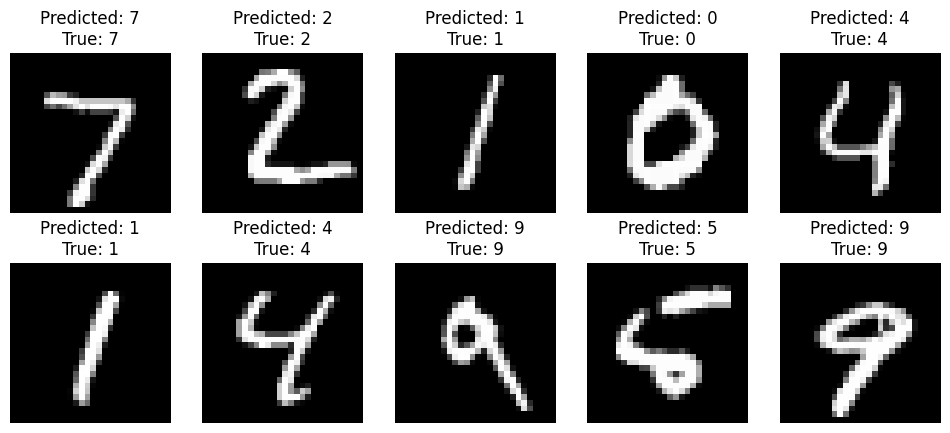

In [11]:
# visualize the result

from matplotlib import pyplot as plt 

n = 10
plt.figure(figsize=(12, 5))
for i in range(n):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title('Predicted: {}\nTrue: {}'.format(
        mnist_labels[np.argmax(my_lenet.predict(x_test[i:i+1], verbose=None))],
        mnist_labels[y_test[i]]
    ))
    plt.axis('off')
plt.show()


looks good!

## 2. Train the model using a custom visual dataset

This section is to help you create a training data for a specific task. The sample I use is to categorize dog and cat images using lenet5 model.

In [12]:
# at first, download it from the gdrive id
# install gdown: python -m pip install gdown

!gdown  1FP3NB3diInw-kIno5aU3w7DAZUaKFWla -O cat-dog.zip

^C


Downloading...
From (original): https://drive.google.com/uc?id=1FP3NB3diInw-kIno5aU3w7DAZUaKFWla
From (redirected): https://drive.google.com/uc?id=1FP3NB3diInw-kIno5aU3w7DAZUaKFWla&confirm=t&uuid=72049fd7-3e85-432e-bcf9-218d2a79848b
To: cat-dog.zip

  0%|          | 0.00/570M [00:00<?, ?B/s]
  0%|          | 524k/570M [00:00<04:46, 1.98MB/s]
  0%|          | 1.57M/570M [00:00<03:57, 2.39MB/s]
  1%|          | 3.15M/570M [00:00<02:19, 4.06MB/s]
  1%|          | 3.67M/570M [00:01<02:15, 4.17MB/s]
  1%|          | 4.72M/570M [00:01<02:22, 3.97MB/s]
  1%|          | 6.29M/570M [00:01<01:37, 5.79MB/s]
  1%|▏         | 7.34M/570M [00:01<01:50, 5.09MB/s]
  1%|▏         | 8.39M/570M [00:01<01:45, 5.30MB/s]
  2%|▏         | 9.44M/570M [00:01<01:34, 5.90MB/s]
  2%|▏         | 10.5M/570M [00:02<02:19, 4.01MB/s]
  2%|▏         | 11.5M/570M [00:02<03:04, 3.02MB/s]
  2%|▏         | 12.1M/570M [00:03<03:03, 3.04MB/s]
  2%|▏         | 13.6M/570M [00:03<03:14, 2.86MB/s]
  3%|▎         | 15.2M/570M [00:

In [ ]:
# unpack it
import zipfile

assert os.path.exists('cat-dog.zip'), 'File not found'
with zipfile.ZipFile('cat-dog.zip', 'r') as zip_ref:
    zip_ref.extractall('cat-dog-dataset')

: 

In [ ]:
# now let's see the dataset structure

%ls cat-dog-dataset\train

 Volume in drive XX is work
 Volume Serial Number is <MASKED>

 Directory of cat-dog-dataset\train

07/05/2024  03:11 PM    <DIR>          .
07/05/2024  03:11 PM    <DIR>          ..
07/05/2024  03:11 PM            12,414 cat.0.jpg
07/05/2024  03:11 PM            16,880 cat.1.jpg
07/05/2024  03:11 PM            34,315 cat.10.jpg
07/05/2024  03:11 PM            28,377 cat.100.jpg
07/05/2024  03:11 PM             5,944 cat.1000.jpg
07/05/2024  03:11 PM            21,944 cat.10000.jpg
07/05/2024  03:11 PM            27,322 cat.10001.jpg
07/05/2024  03:11 PM            25,723 cat.10002.jpg
07/05/2024  03:11 PM            28,035 cat.10003.jpg
07/05/2024  03:11 PM            12,973 cat.10004.jpg
07/05/2024  03:11 PM             8,245 cat.10005.jpg
07/05/2024  03:11 PM            24,153 cat.10006.jpg
07/05/2024  03:11 PM            10,328 cat.10007.jpg
07/05/2024  03:11 PM            25,222 cat.10008.jpg
07/05/2024  03:11 PM            21,281 cat.10009.jpg
07/05/2024  03:11 PM            23,0

In [13]:
# the train data file has fmt label.<id>.jpg
# now define a function to load it

import re, cv2, glob

pattern = re.compile(r'(\w+)\.(\d+)\.jpg')

labels_map = {
    'cat': 0,
    'dog': 1
}

def load_item(path):
    name = os.path.split(path)[-1]
    label, _ = pattern.match(name).groups()
    return cv2.imread(path), labels_map[label]

In [14]:
# index data files, load and split 

train_files = glob.glob('cat-dog-dataset/train/*.jpg')
print('Total data files:', len(train_files)) 

train_ratio = .7
train_files = np.random.permutation(train_files)

train_files = train_files[:int(len(train_files) * train_ratio)]
val_files = train_files[int(len(train_files) * train_ratio):]

print('Train files:', len(train_files))
print('Validation files:', len(val_files))

Total data files: 25000
Train files: 17500
Validation files: 5250


In [15]:
# now we load and transform data manually
x_train, y_train, x_test, y_test = [], [], [], []
img_input_size = (64, 64) # we use larger image for this task


In [16]:

import tqdm 

for path in tqdm.tqdm(train_files, desc='Loading train data'):
    x, y = load_item(path)

    x = cv2.resize(x, img_input_size)

    x_train.append(x)
    y_train.append(y)

for path in tqdm.tqdm(val_files, desc='Loading validation data'):
    x, y = load_item(path)

    x = cv2.resize(x, img_input_size)

    x_test.append(x)
    y_test.append(y)

# construct np.arrays for the next steps
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

print('Shape:', x_train.shape, y_train.shape, x_test.shape, y_test.shape)

Loading validation data: 100%|██████████| 5250/5250 [00:05<00:00, 1030.17it/s]

Shape: (17500, 64, 64, 3) (17500,) (5250, 64, 64, 3) (5250,)


In [17]:
# now normalize the data

x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

In [18]:
# create a lenet model 
# in this task, the input is 3-channel image, so we have to change the input shape

lenet_5_cat_dog_classification_model = create_lenet5_for_classification(
    x_train.shape[1:],
    len(labels_map)
)

lenet_5_cat_dog_classification_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

lenet_5_cat_dog_classification_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │        32,770 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,162 (203.76 KB)

 Trainable params: 52,162 (203.76 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# train the model

lenet_5_cat_dog_classification_model.fit(
    x_train,
    keras.utils.to_categorical(y_train, len(labels_map)),
    batch_size=128,
    epochs=10,
    validation_split=0.2
)

Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.5604 - loss: 0.6842 - val_accuracy: 0.6866 - val_loss: 0.5991
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.7122 - loss: 0.5659 - val_accuracy: 0.7209 - val_loss: 0.5530
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.7464 - loss: 0.5152 - val_accuracy: 0.7480 - val_loss: 0.5145
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.7656 - loss: 0.4899 - val_accuracy: 0.7577 - val_loss: 0.5052
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.7883 - loss: 0.4674 - val_accuracy: 0.7689 - val_loss: 0.4782
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.8029 - loss: 0.4367 - val_accuracy: 0.7777 - val_loss: 0.4691
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.8118 - loss: 0.4215 - val_accuracy: 0.7657 - val_loss: 0.4889
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.8088 - loss: 0.4201 - val_accu

In [20]:
# now we test it

test_loss, test_acc = lenet_5_cat_dog_classification_model.evaluate(
    x_test,
    keras.utils.to_categorical(y_test, len(labels_map))
)

print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8422 - loss: 0.3608
Test accuracy: 0.8161904811859131
Test loss: 0.4019777178764343


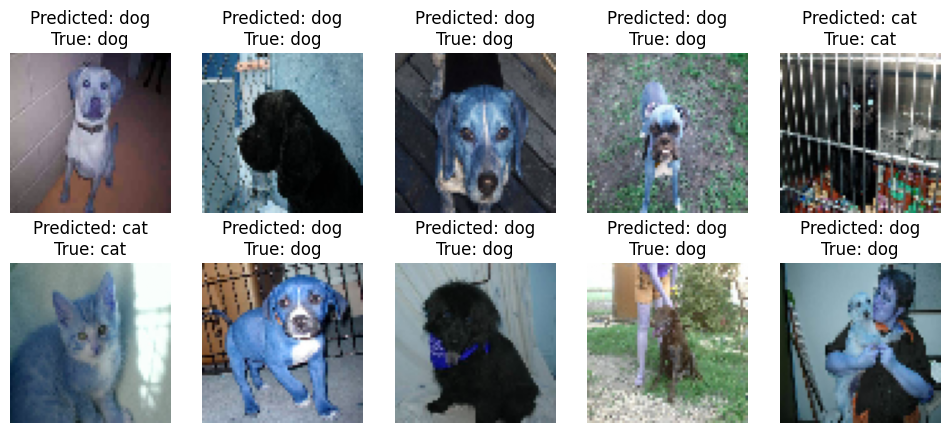

In [21]:
# visualize the result

n = 10
plt.figure(figsize=(12, 5))

for i in range(n):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[i])
    plt.title('Predicted: {}\nTrue: {}'.format(
        list(labels_map.keys())[np.argmax(lenet_5_cat_dog_classification_model.predict(x_test[i:i+1], verbose=None))],
        list(labels_map.keys())[y_test[i]]
    ))
    plt.axis('off')

## 3. Deploy on-chain models.

Ensure your model must be a Keras model. Moreover, It should be trained before saving it on-chain. This step requires help from our development pack. Install it via pip:

In [ ]:
!pip install git+https://github.com/eternalai-org/eternalai.git@v1.0.0

  Cloning https://github.com/eternalai-org/eternalai.git (to revision v1.0.0) to c:\users\dell\appdata\local\temp\pip-req-build-5a2j_q9h
  Resolved https://github.com/eternalai-org/eternalai.git to commit 236d845e58861176e9bfe70c7461f12968a8871f
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached loguru-0.7.2-py3-none-any.whl.metadata (23 kB)
  Using cached win32_setctime-1.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached jsonschema-4.22.0-py3-none-any.whl.metadata (8.2 kB)
     ---------------------------------------- 0.0/515.5 kB ? eta -:--:--
     ---------------------------------------- 0.0/515.5 kB ? eta -:--:--
     ---------------------------------------- 0.0/515.5 kB ? eta -:--:--
     - -------------------------------------- 20.5/515.5 kB ? eta -:--:--
     - -------------------------------------- 20.5/515.5 kB ? eta -:--:--
     -- ---------------------------------- 30.7/515.5 kB 262.6 kB/s eta 0:00:02
    

  Running command git clone --filter=blob:none --quiet https://github.com/eternalai-org/eternalai.git 'C:\Users\DELL\AppData\Local\Temp\pip-req-build-5a2j_q9h'
  Running command git checkout -q 236d845e58861176e9bfe70c7461f12968a8871f


In [22]:
# just to make sure the installation was successful:

!eai version

2024-07-05 16:51:26 | SUCCESS  | eai.cli:main:130 - ✨ EternalAI Builder - Version: 1.0.0 ✨


In [30]:
# once step initialization

!eai init --private-key <guess my private key :d>

The syntax of the command is incorrect.


In [27]:
# import the toolkit 

import eai

In [32]:
lenet5_mnist_address = eai.publish(
    my_lenet, 
    model_name = "lenet5_mnist_202407"
)

2024-07-05 17:04:46 | INFO     | eai.func:publish:31 - Saving model ...
2024-07-05 17:04:46 | INFO     | eai.exporter:_export_tf_model:164 - Exporting Tensorflow/Keras model ...
2024-07-05 17:04:46 | INFO     | eai.exporter:_export_model_graph:64 - Exporting model graph ...
2024-07-05 17:04:46 | SUCCESS  | eai.exporter:_export_model_graph:82 - Layer InputLayer exported
2024-07-05 17:04:46 | SUCCESS  | eai.exporter:_export_model_graph:82 - Layer Conv2D exported
2024-07-05 17:04:46 | SUCCESS  | eai.exporter:_export_model_graph:82 - Layer MaxPooling2D exported
2024-07-05 17:04:46 | SUCCESS  | eai.exporter:_export_model_graph:82 - Layer Conv2D exported
2024-07-05 17:04:46 | SUCCESS  | eai.exporter:_export_model_graph:82 - Layer MaxPooling2D exported
2024-07-05 17:04:46 | SUCCESS  | eai.exporter:_export_model_graph:82 - Layer Flatten exported
2024-07-05 17:04:46 | SUCCESS  | eai.exporter:_export_model_graph:82 - Layer Dense exported
2024-07-05 17:04:46 | SUCCESS  | eai.exporter:_export_mode

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [36]:
lenet5_dogcat_address = eai.publish(
    lenet_5_cat_dog_classification_model,
    model_name = "lenet5_dogcat_202407"
)

2024-07-05 17:22:32 | INFO     | eai.func:publish:31 - Saving model ...
2024-07-05 17:22:32 | INFO     | eai.exporter:_export_tf_model:164 - Exporting Tensorflow/Keras model ...
2024-07-05 17:22:32 | INFO     | eai.exporter:_export_model_graph:64 - Exporting model graph ...
2024-07-05 17:22:32 | SUCCESS  | eai.exporter:_export_model_graph:82 - Layer InputLayer exported
2024-07-05 17:22:32 | SUCCESS  | eai.exporter:_export_model_graph:82 - Layer Conv2D exported
2024-07-05 17:22:32 | SUCCESS  | eai.exporter:_export_model_graph:82 - Layer MaxPooling2D exported
2024-07-05 17:22:32 | SUCCESS  | eai.exporter:_export_model_graph:82 - Layer Conv2D exported
2024-07-05 17:22:32 | SUCCESS  | eai.exporter:_export_model_graph:82 - Layer MaxPooling2D exported
2024-07-05 17:22:32 | SUCCESS  | eai.exporter:_export_model_graph:82 - Layer Flatten exported
2024-07-05 17:22:32 | SUCCESS  | eai.exporter:_export_model_graph:82 - Layer Dense exported
2024-07-05 17:22:32 | SUCCESS  | eai.exporter:_export_mode

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

## 4. Make on-chain prediction

Ensure your `input_tensor` is preprocessed to match the model’s expected input format.

In [29]:
sample = x_test[0:1]
sample.shape

(1, 64, 64, 3)

In [ ]:
output_tensor = eai.predict(lenet5_dogcat_address, sample)

In [35]:
lenet_5_cat_dog_classification_model.save('lenet5_dogcat_202407.h5')
my_lenet.save('lenet5_mnist_202407.h5')